# Composition of food - an exploration

Original idea on a linkedin post by Nicola Rennie

https://www.linkedin.com/posts/nicola-rennie_activity-7373337363122634752


Her original idea was to use ternary plots to display the differences in protein, fat and carbohydrads contents between different cuisines.

I am here testing a german version which was not done in the post. The idea is three-fold
1) Plotting ternary data in python
2) Using ILR (isometric log-ratio)
3) Using the resulting data for a infographics


References:
- Aitchison, The Statistical Analysis of Compositional Data, 1986.
- Egozcue et al., “Isometric logratio transformations for compositional data analysis,” Mathematical Geology, 2003.
- Pawlowsky-Glahn, Egozcue, Tolosana-Delgado, Modeling and Analysis of Compositional Data, 2015.




In [194]:
import os

import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import mpltern # ternary plot
from matplotlib.colors import ListedColormap  # list of colors for accessing colours directly
import matplotlib.patches as mpatches # custom legend

from matplotlib.transforms import offset_copy # for labeling
import matplotlib.patheffects as pe           # path effects

# Loading data

Kaggle data set: https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions/data

In [2]:
food = pd.read_csv('RAW_recipes.csv')

In [3]:
food.columns

Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients'],
      dtype='object')

In [4]:
print(food.shape)

food.drop_duplicates(subset = 'id', inplace = True)

print(food.shape)

(231637, 12)
(231637, 12)


In [6]:
# converting the string lists into real lists
food['nutrition_list'] = food['nutrition'].apply(ast.literal_eval)

In [7]:
# extracting calories (0), fat (PDV) (1), protein (PDV) (4) and carbohydrates (6)
# PDV stands for “percentage of daily value”
food['calories']     = food['nutrition_list'].str.get(0)
food['fats_pdv']     = food['nutrition_list'].str.get(1)
food['carbs_pdv']    = food['nutrition_list'].str.get(6)
food['proteins_pdv'] = food['nutrition_list'].str.get(4)


Since the values for fat, protein and carbs is in percentage of daily volume, we need to recover the actual values.
The FDA states specific values for daily intake (DV=100%), specifically 78 g fat, 275 g carbs, and 50 g protein for adults and children over the age of four.

$$
  g_{f} = \frac{fat\ PDV}{100}\cdot 78\,g, \qquad
  g_{c} = \frac{carbs\ PDV}{100}\cdot 275\,g, \qquad
  g_{p} = \frac{proteins\ PDV}{100}\cdot 50\,g,
$$


In [8]:
food['fats_g']     = food['fats_pdv']*78.0/100.0
food['carbs_g']    = food['carbs_pdv']*275.0/100.0
food['proteins_g'] = food['proteins_pdv']*50.0/100.0

# to renormalize we need the total grams
food['total_g']= food['fats_g']+food['carbs_g']+food['proteins_g']

# later we want to classify low carb and low fat, energy ratios is the standard
food['E_fats']     = 9 * food['fats_g']
food['E_carbs']    = 4 * food['carbs_g']
food['E_proteins'] = 4 * food['proteins_g']

# to normalize we need the total energy
food['E_total']    = food['E_fats'] + food['E_carbs'] + food['E_proteins']

In [9]:
# normalize to get percentage of the whole
food['fats_perc']     = food['fats_g'] / food['total_g']
food['carbs_perc']    = food['carbs_g'] / food['total_g']
food['proteins_perc'] = food['proteins_g'] / food['total_g']

# normalize to get percentage of the whole
food['E_fats_perc']       = food['E_fats'] / food['E_total']
food['E_carbs_perc']      = food['E_carbs'] / food['E_total']
food['E_proteins_perc']   = food['E_proteins'] / food['E_total']


In [10]:
# define low carb as carb percentage < 26%
food['low_carb'] = food['E_carbs_perc'].apply(lambda x: 1 if x < 0.26 else 0)
food['low_fat']  = food['E_fats_perc'].apply(lambda x: 1 if x < 0.3 else 0)

# We also differentiate main, dessert and other
food['dessert'] = (food['tags'].str.contains('dessert')).map({True: 1, False : 0})
food['main']    = (food['tags'].str.contains('main')).map({True: 1, False : 0})


In [11]:
food['low_fat'].sum()

np.int64(54458)

# display data using a ternary plot

## Plot by gram percentage

In [178]:
# save plot
filename = f'MainCourseRecipesTaggedFrenchGermanItalian-ternaryPlot_energy.png'
dpi = 120

fig.savefig(filename, dpi=dpi, bbox_inches="tight")


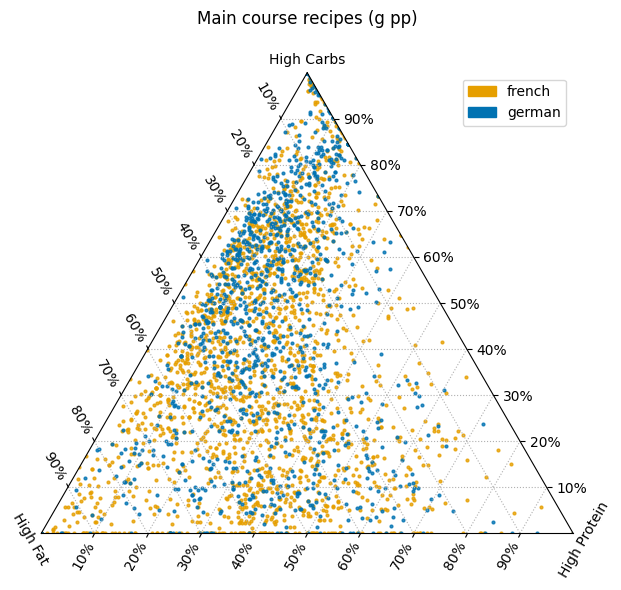

In [179]:
# restrict main dishes to keyword

df = food[food['tags'].str.contains('main')].copy()

# select german
df_de = df[df['tags'].str.contains('german')].copy()

# select french
df_fr = df[df['tags'].str.contains('french')].copy()

# plotting using mpltern library
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection="ternary")

ax.scatter(
    df_fr['carbs_perc'], 
    df_fr['fats_perc'], 
    df_fr['proteins_perc'],
    s = 4, # marker size
    alpha = 0.8,
    color = '#E69F00'
    # c = df['low_carb'],
    # cmap = cmap,
)

ax.scatter(
    df_de['carbs_perc'], 
    df_de['fats_perc'], 
    df_de['proteins_perc'],
    s = 4, # marker size
    alpha = 0.8,
    color = '#0072B2',
    # c = df['low_carb'],
    # cmap = cmap,
)
    
# linspace to create 10% increments
ticks = np.linspace(0.1, 0.9, 9)

# applying the ticks to all three axii
ax.taxis.set_ticks(ticks)
ax.taxis.set_ticklabels([f"{int(100*v)}%" for v in ticks])

ax.laxis.set_ticks(ticks)
ax.laxis.set_ticklabels([f"{int(100*v)}%" for v in ticks])

ax.raxis.set_ticks(ticks)
ax.raxis.set_ticklabels([f"{int(100*v)}%" for v in ticks])

# Labels and grid
ax.set_tlabel("High Carbs")
ax.set_llabel("High Fat")
ax.set_rlabel("High Protein")
ax.grid(True, linestyle=":")

# custom legend
handles = [
    mpatches.Patch(color="#E69F00", label="french"),
    mpatches.Patch(color="#0072B2", label="german"),
]
ax.legend(handles=handles, loc="best")

ax.set_title(f"Main course recipes (g pp)\n")
plt.tight_layout()
plt.show()



In [180]:
# save plot
filename = f'MainCourseRecipesTaggedFrench-ternaryPlot_gpp.png'
dpi = 120

fig.savefig(filename, dpi=dpi, bbox_inches="tight")

# ILR Coordinates

To use euclidean methods on ternary data we use isomteric log-ratio coordinates. The idea is to transform $x_1,x_2,x_3$ with $x_1+x_2+x_3=1$ and positive to euclidean space. The transform is

$$ z_1 = \sqrt{\frac{1}{2}}\ln\frac{x_1}{x_2}, \qquad z_2=\sqrt{\frac{2}{3}}\ln\frac{\sqrt{x_1x_2}}{x_3} $$

In [ ]:
# x_1 = carb, x_2 = fat, x_3 = protein

food['e_z1'] = (1/np.sqrt(2))*np.log(food['carbs_perc']/food['fats_perc'])
food['e_z2'] = (np.sqrt(2/3))*np.log((food['fats_perc']*food['carbs_perc'])/food['proteins_perc'])


In [182]:
df = food[food['tags'].str.contains('main')].copy()

# select german
df_de = df[df['tags'].str.contains('german')].copy()
# replace inf, -inf with nan
df_de.replace([np.inf, -np.inf], np.nan, inplace=True)
# drop nans
df_de = df_de.dropna(axis = 0,how = 'all', subset = ['e_z1', 'e_z2'])
# size 
print('shape_de', df_de.shape)
# centroid of de subset
print(c_de := df_de[['e_z1', 'e_z2']].mean())
# covariance
print('covariance fr:', s1 := df_de[['e_z1', 'e_z2']].cov())

# select french
df_fr = df[df['tags'].str.contains('french')].copy()
# replace inf, -inf with nan
df_fr.replace([np.inf, -np.inf], np.nan, inplace=True)
# drop nans
df_fr = df_fr.dropna(axis = 0,how = 'all', subset = ['e_z1', 'e_z2'])
# size 
print('shape_de', df_fr.shape)
# centroid of fr subset
print(c_fr := df_fr[['e_z1', 'e_z2']].mean())
# covariance
print('covariance fr:', s2 := df_fr[['e_z1', 'e_z2']].cov())

# computing centroid shift
print('centroid shift:',c_shift := np.linalg.norm(c_de-c_fr))

sp = 0.5*(s1+s2)
print('sp:',sp) 
d_maha = float(np.sqrt(c_de.values @ np.linalg.inv(sp) @ c_fr.values))
print('mahalonobis distance:',d_maha)


shape_de (1036, 37)
e_z1    0.167140
e_z2   -0.366691
dtype: float64
covariance fr:           e_z1      e_z2
e_z1  0.902771  0.282754
e_z2  0.282754  1.081433
shape_de (1771, 37)
e_z1   -0.070371
e_z2   -0.492460
dtype: float64
covariance fr:           e_z1      e_z2
e_z1  0.961242  0.289152
e_z2  0.289152  1.191420
centroid shift: 0.26875498820337695
sp:           e_z1      e_z2
e_z1  0.932007  0.285953
e_z2  0.285953  1.136426
mahalonobis distance: 0.4183920888157327


# Back transform
$$ 
y_1 =   \frac{z_1}{\sqrt2} +\frac{z_2}{\sqrt6},\qquad
y_2 = - \frac{z_1}{\sqrt2} +\frac{z_2}{\sqrt6},\qquad
y_3 = - \frac{2z_2}{\sqrt6},\qquad
x_i = \frac{\exp(y_i)}{\sum_{k=1}^3\exp(y_k)}
$$

In [183]:
# centroids c_de and c_fr need to be backtransformed
def backtransform_ILR(z1, z2):
    sqr2 = np.sqrt(2)
    sqr6 = np.sqrt(6)

    y1 =  z1 / sqr2 + z2 / sqr6
    y2 = -z1 / sqr2 + z2 / sqr6
    y3 = -2*z2 / sqr6

    sum_y = np.exp(y1)+np.exp(y2)+np.exp(y3)
    x1 = np.exp(y1)/sum_y
    x2 = np.exp(y2)/sum_y
    x3 = np.exp(y3)/sum_y

    return [x1, x2, x3]

c_de_bt = backtransform_ILR(c_de.iloc[0], c_de.iloc[1])
c_fr_bt = backtransform_ILR(c_fr.iloc[0], c_fr.iloc[1])

print('Centroid (german) in ternary:', c_de_bt)
print('Centroid (french) in ternary:', c_fr_bt)
print('Delta (french-german) fats    :', c_fr_bt[0]-c_de_bt[0])
print('Delta (french-german) carbs   :', c_fr_bt[1]-c_de_bt[1])
print('Delta (french-german) proteins:', c_fr_bt[2]-c_de_bt[2])

Centroid (german) in ternary: [np.float64(0.31429427997447373), np.float64(0.24813139288600272), np.float64(0.43757432713952354)]
Centroid (french) in ternary: [np.float64(0.2484015870352656), np.float64(0.2743943641243534), np.float64(0.4772040488403809)]
Delta (french-german) fats    : -0.06589269293920813
Delta (french-german) carbs   : 0.026262971238350696
Delta (french-german) proteins: 0.03962972170085738


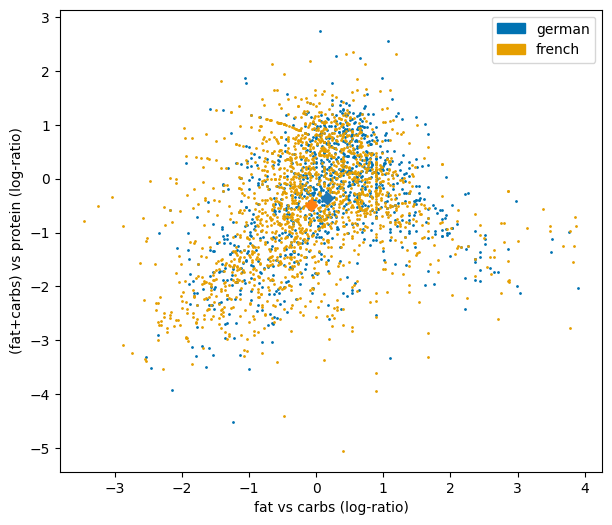

In [211]:
fig, ax = plt.subplots(figsize=(7, 6))

ax.scatter(
    df_de['e_z1'],
    df_de['e_z2'],
    s = 1,
    c = '#0072B2',
)

ax.scatter(
    df_fr['e_z1'],
    df_fr['e_z2'],
    s = 1,
    c = '#E69F00',
)

# plot centroid
ax.plot(
    c_de.iloc[0],
    c_de.iloc[1],
    linestyle = 'none',
    marker = 'D',
)

ax.plot(
    c_fr.iloc[0],
    c_fr.iloc[1],
    linestyle = 'none',
    marker = 'D',
)

# Labels and grid
ax.set_xlabel('fat vs carbs (log-ratio)')
ax.set_ylabel('(fat+carbs) vs protein (log-ratio)')

# custom legend
handles = [
    mpatches.Patch(color="#0072B2", label="german"),
    mpatches.Patch(color="#E69F00", label="french"),
]
ax.legend(handles=handles, loc="best")

In [212]:
# save plot
filename = f'MainCourseRecipesTaggedFrenchGerman-gpp-ILR.png'
dpi = 120

fig.savefig(filename, dpi=dpi, bbox_inches="tight")

# Plot again in ternary for final result display

In [206]:
def draw_constant_band(ax, axis, v1, v2, *, scale=1.0, N=200,
                       color="black", line_kwargs=None, fill_kwargs=None):
    # (same as before) — draws the two constant-component lines and shades between
    axis = axis.lower(); assert axis in {"t","l","r"}
    low, high = sorted([float(v1), float(v2)])
    lk = dict(ls="--", lw=1.5, color=color); lk.update(line_kwargs or {})
    fk = dict(facecolor=color, alpha=0.15, edgecolor="none"); fk.update(fill_kwargs or {})

    if axis == "t":
        l1 = np.linspace(0, scale-low, N); r1 = scale-low-l1; t1 = np.full(N, low)
        l2 = np.linspace(0, scale-high, N); r2 = scale-high-l2; t2 = np.full(N, high)
    elif axis == "l":
        t1 = np.linspace(0, scale-low, N); r1 = scale-low-t1; l1 = np.full(N, low)
        t2 = np.linspace(0, scale-high, N); r2 = scale-high-t2; l2 = np.full(N, high)
    else:  # axis == "r"
        t1 = np.linspace(0, scale-low, N); l1 = scale-low-t1; r1 = np.full(N, low)
        t2 = np.linspace(0, scale-high, N); l2 = scale-high-t2; r2 = np.full(N, high)

    ax.plot(t1, l1, r1, **lk); ax.plot(t2, l2, r2, **lk)
    T = np.concatenate([t1, t2[::-1]]); L = np.concatenate([l1, l2[::-1]]); R = np.concatenate([r1, r2[::-1]])
    ax.fill(T, L, R, **fk)

def annotate_axis_gap(ax, axis, v1, v2, *, scale=1.0, at=0.5,
                      color="black", lw=2.0, label=None, text_kw=None):
    """
    Draw a short double-ended segment parallel to the chosen axis between v1 and v2,
    positioned at fraction 'at' (0..1) across the band, with a label Δ.
    """
    axis = axis.lower(); assert axis in {"t","l","r"}
    low, high = sorted([float(v1), float(v2)])
    gap = abs(high - low)
    txt = label if label is not None else f"Δ{axis} = {gap:.2g}"

    if axis == "t":
        # place inside both lines at l = at*(scale - high)
        l = at*(scale - high)
        p_lo = (low,  l,  scale - low  - l)
        p_hi = (high, l,  scale - high - l)
    elif axis == "l":
        t = at*(scale - high)
        p_lo = (scale - low  - t, low, t)
        p_hi = (scale - high - t, high, t)
    else:  # 'r'
        t = at*(scale - high)
        p_lo = (t, scale - low  - t, low)
        p_hi = (t, scale - high - t, high)

    # draw the segment and end caps
    ax.plot([p_lo[0], p_hi[0]], [p_lo[1], p_hi[1]], [p_lo[2], p_hi[2]],
            color=color, lw=lw, zorder= 10, clip_on= False)
    ax.scatter([p_lo[0], p_hi[0]], [p_lo[1], p_hi[1]], [p_lo[2], p_hi[2]],
               s=20, facecolors=color, edgecolors="black", linewidths=0.8, zorder=11, clip_on=False)

    # label near the upper endpoint
    tk = dict(ha="left", va="bottom", fontsize=10, color=color); tk.update(text_kw or {})
    ax.text(p_hi[0], p_hi[1], p_hi[2], txt, **tk)

def label_point(ax, t, l, r, text, dx=6, dy=6, units='points', color="black", **kw):
    trans = offset_copy(ax.transData, fig=ax.figure, x=dx, y=dy, units=units)
    return ax.text(t, l, r, text, transform=trans, color=color,
                   va="bottom", ha="left",
                   path_effects=[pe.withStroke(linewidth=3, foreground="white")],
                   **kw)

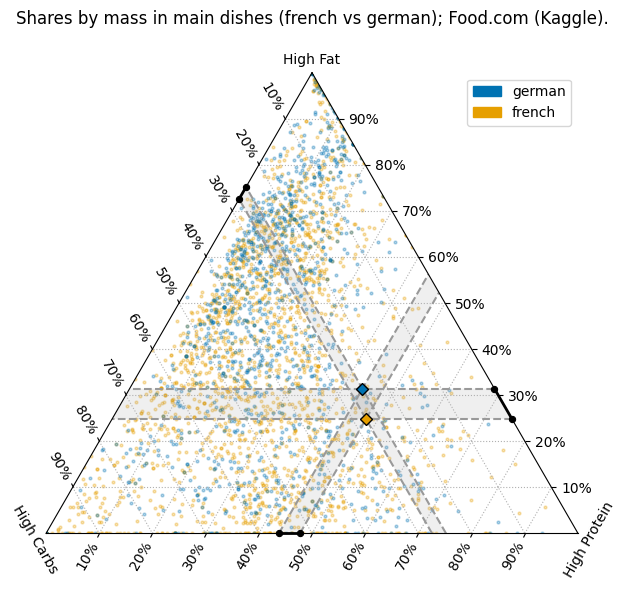

In [209]:
# restrict main dishes to keyword

df = food[food['tags'].str.contains('main')].copy()

# select german
df_de = df[df['tags'].str.contains('german')].copy()

# select french
df_fr = df[df['tags'].str.contains('french')].copy()

# plotting using mpltern library
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection="ternary")

ax.scatter(
    df_fr['carbs_perc'], 
    df_fr['fats_perc'], 
    df_fr['proteins_perc'],
    s = 4, # marker size
    alpha = 0.3,
    color = '#E69F00'
    # c = df['low_carb'],
    # cmap = cmap,
)

ax.scatter(
    df_de['carbs_perc'], 
    df_de['fats_perc'], 
    df_de['proteins_perc'],
    s = 4, # marker size
    alpha = 0.3,
    color = '#0072B2',
    # c = df['low_carb'],
    # cmap = cmap,
)

# draw some helper lines
draw_constant_band(
    ax,
    't',
    c_de_bt[0], c_fr_bt[0],
    color="#999999"
)
annotate_axis_gap(
    ax,
    't', 
    c_de_bt[0], c_fr_bt[0],
    at=0,
    color="#000000",
    label = '',# label="Δcarbs ≈ 5.8 pp"
)

draw_constant_band(ax, 'l', c_de_bt[1], c_fr_bt[1], color="#999999")
annotate_axis_gap(
    ax,
    'l', 
    c_de_bt[1], c_fr_bt[1],
    at=0,
    color="#000000",
    label = '',# label="Δcarbs ≈ 5.8 pp"
)

draw_constant_band(ax, 'r', c_de_bt[2], c_fr_bt[2], color="#999999")
annotate_axis_gap(
    ax,
    'r', 
    c_de_bt[2], c_fr_bt[2],
    at=0,
    color="#000000",
    label = '',# label="Δcarbs ≈ 5.8 pp"
)


# add the centroids of the cluster
ax.plot(
    c_de_bt[0],
    c_de_bt[1],
    c_de_bt[2],
    linestyle = 'none',
    marker = 'D',
    markerfacecolor = '#0072B2',
    markeredgecolor = 'black',
)
            
ax.plot(
    c_fr_bt[0],
    c_fr_bt[1],
    c_fr_bt[2],
    linestyle = 'none',
    marker = 'D',
    markerfacecolor = '#E69F00',
    markeredgecolor = 'black',
)

# linspace to create 10% increments
ticks = np.linspace(0.1, 0.9, 9)

# applying the ticks to all three axii
ax.taxis.set_ticks(ticks)
ax.taxis.set_ticklabels([f"{int(100*v)}%" for v in ticks])

ax.laxis.set_ticks(ticks)
ax.laxis.set_ticklabels([f"{int(100*v)}%" for v in ticks])

ax.raxis.set_ticks(ticks)
ax.raxis.set_ticklabels([f"{int(100*v)}%" for v in ticks])

# Labels and grid
ax.set_tlabel("High Fat")
ax.set_llabel("High Carbs")
ax.set_rlabel("High Protein")
ax.grid(True, linestyle=":")

# custom legend
handles = [
    mpatches.Patch(color="#0072B2", label="german"),
    mpatches.Patch(color="#E69F00", label="french"),
]
ax.legend(handles=handles, loc="best")

ax.set_title(f"Shares by mass in main dishes (french vs german); Food.com (Kaggle).\n")
plt.tight_layout()
plt.show()



In [210]:
# save plot
filename = f'MainCourseRecipesTaggedFrenchGerman-gpp-centroids.png'
dpi = 120

fig.savefig(filename, dpi=dpi, bbox_inches="tight")